In [1]:
!pip install -q imbalanced-learn

In [26]:
# Imports utama
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

import joblib
import warnings
warnings.filterwarnings('ignore')

print("Libraries loaded.")

Libraries loaded.


In [27]:
df = pd.read_csv("data-bank.csv")
print("Dataset shape:", df.shape)
df.head()

Dataset shape: (6819, 96)


,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


In [28]:
cols = df.columns
print("Columns:", cols.tolist())

# cari nama kolom target
possible_targets = ['bankrupt', 'bankruptcy', 'is_bankrupt', 'class', 'target', 'y']
target_col = None

for c in cols:
    if any(key in c.lower() for key in possible_targets):
        target_col = c
        break

# fallback: pilih kolom terakhir
if target_col is None:
    target_col = cols[-1]
    print("PERINGATAN: Kolom target tidak ditemukan. Menggunakan kolom terakhir:", target_col)
else:
    print("Kolom target terdeteksi:", target_col)

df[target_col].value_counts()

Columns: ['Bankrupt?', ' ROA(C) before interest and depreciation before interest', ' ROA(A) before interest and % after tax', ' ROA(B) before interest and depreciation after tax', ' Operating Gross Margin', ' Realized Sales Gross Margin', ' Operating Profit Rate', ' Pre-tax net Interest Rate', ' After-tax net Interest Rate', ' Non-industry income and expenditure/revenue', ' Continuous interest rate (after tax)', ' Operating Expense Rate', ' Research and development expense rate', ' Cash flow rate', ' Interest-bearing debt interest rate', ' Tax rate (A)', ' Net Value Per Share (B)', ' Net Value Per Share (A)', ' Net Value Per Share (C)', ' Persistent EPS in the Last Four Seasons', ' Cash Flow Per Share', ' Revenue Per Share (Yuan ¥)', ' Operating Profit Per Share (Yuan ¥)', ' Per Share Net profit before tax (Yuan ¥)', ' Realized Sales Gross Profit Growth Rate', ' Operating Profit Growth Rate', ' After-tax Net Profit Growth Rate', ' Regular Net Profit Growth Rate', ' Continuous Net Profi

Bankrupt?
0    6599
1     220
Name: count, dtype: int64

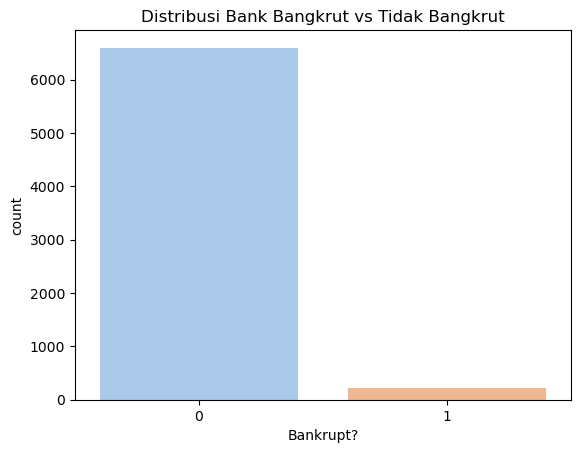

In [29]:
sns.countplot(x=target_col, data=df, palette='pastel')
plt.title("Distribusi Bank Bangkrut vs Tidak Bangkrut")
plt.show()

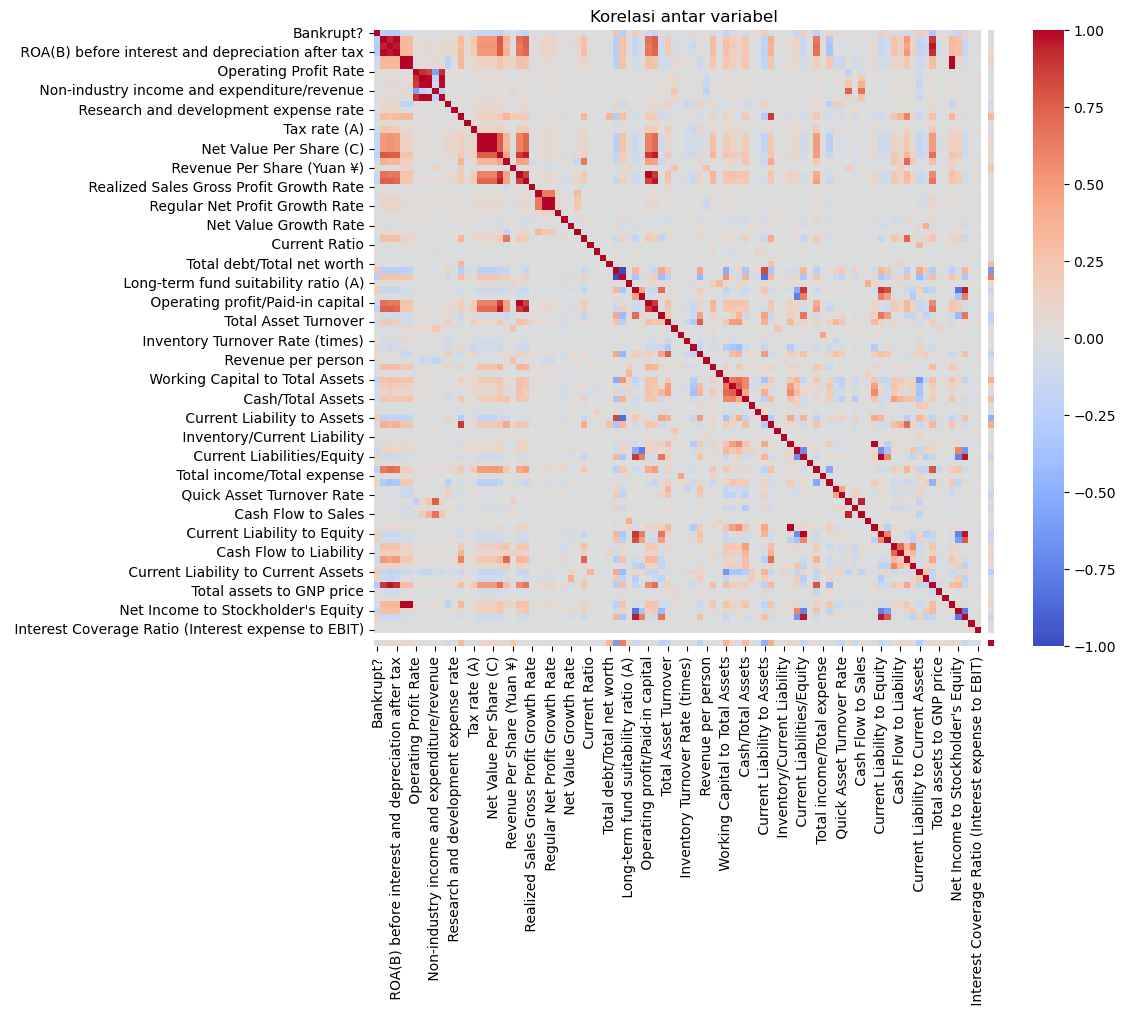

In [30]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), cmap='coolwarm', center=0)
plt.title("Korelasi antar variabel")
plt.show()

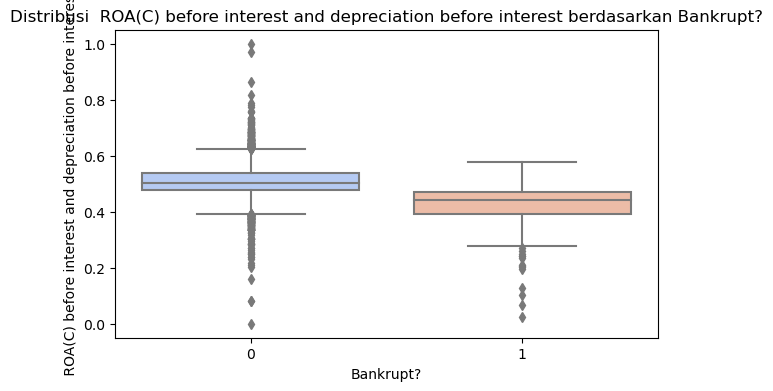

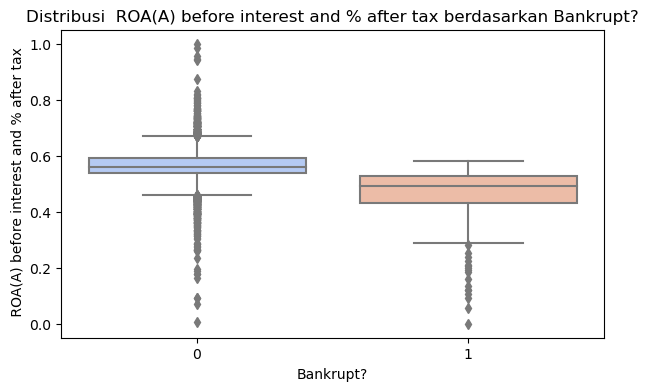

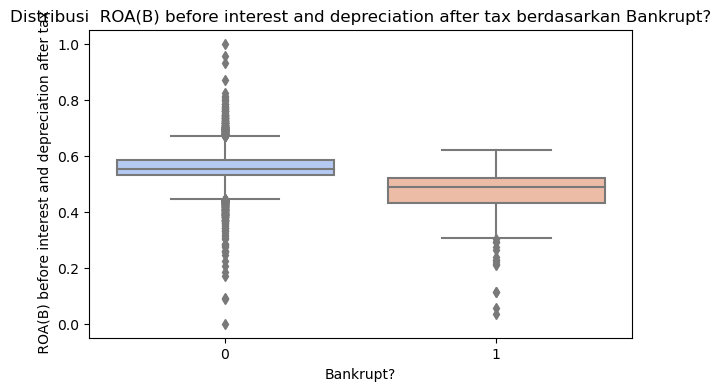

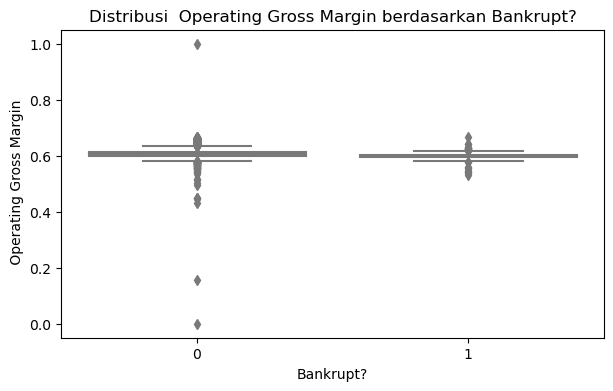

In [31]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

for col in num_cols[:5]:  # tampilkan 5 contoh
    if col != target_col:
        plt.figure(figsize=(7,4))
        sns.boxplot(x=df[target_col], y=df[col], palette='coolwarm')
        plt.title(f"Distribusi {col} berdasarkan {target_col}")
        plt.show()


In [32]:
# drop ID jika ada
for idname in ['id', 'ID', 'Index', 'index', 'No']:
    if idname in df.columns:
        df = df.drop(columns=[idname])

# isi missing values
for col in df.columns:
    if df[col].isnull().sum() > 0:
        if df[col].dtype in [np.float64, np.int64]:
            df[col] = df[col].fillna(df[col].median())
        else:
            df[col] = df[col].fillna(df[col].mode()[0])

print("Missing values:", df.isnull().sum().sum())

Missing values: 0


In [33]:
X = df.drop(columns=[target_col])
y = df[target_col]

# encode jika ada kategori
cat_cols = X.select_dtypes(include=['object']).columns
if len(cat_cols) > 0:
    X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

X.shape, y.shape

((6819, 95), (6819,))

In [34]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train:", X_train.shape, "Test:", X_test.shape)

Train: (5455, 95) Test: (1364, 95)


In [35]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Scaling done.")

Scaling done.


=== DECISION TREE REPORT ===
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      1320
           1       0.27      0.30      0.28        44

    accuracy                           0.95      1364
   macro avg       0.62      0.63      0.63      1364
weighted avg       0.95      0.95      0.95      1364



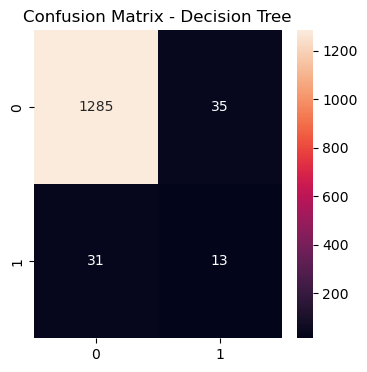

In [36]:
dt = DecisionTreeClassifier(random_state=42, class_weight='balanced')
dt.fit(X_train_scaled, y_train)
y_pred_dt = dt.predict(X_test_scaled)

print("=== DECISION TREE REPORT ===")
print(classification_report(y_test, y_pred_dt))

plt.figure(figsize=(4,4))
sns.heatmap(confusion_matrix(y_test, y_pred_dt), annot=True, fmt='d')
plt.title("Confusion Matrix - Decision Tree")
plt.show()

In [37]:
rf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    class_weight='balanced'
)
rf.fit(X_train_scaled, y_train)

y_pred_rf = rf.predict(X_test_scaled)
y_prob_rf = rf.predict_proba(X_test_scaled)[:,1]

print("=== RANDOM FOREST REPORT ===")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_rf))

=== RANDOM FOREST REPORT ===
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      1320
           1       0.69      0.20      0.32        44

    accuracy                           0.97      1364
   macro avg       0.83      0.60      0.65      1364
weighted avg       0.97      0.97      0.96      1364

ROC-AUC: 0.940650826446281


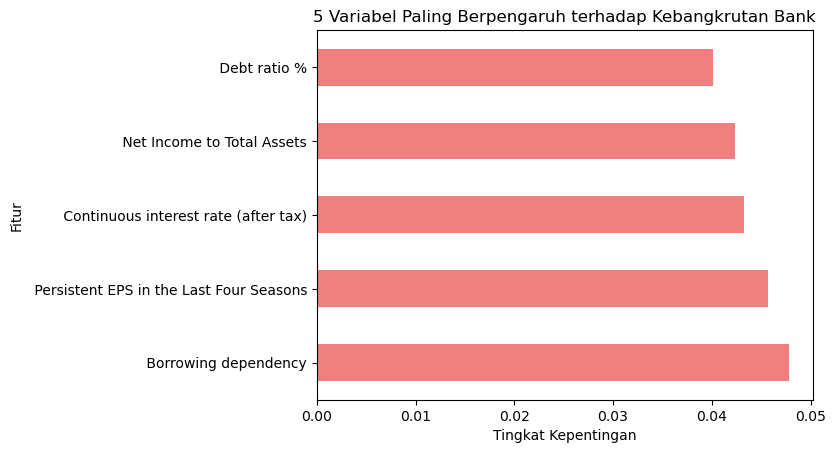

 Borrowing dependency                       0.047822
 Persistent EPS in the Last Four Seasons    0.045662
 Continuous interest rate (after tax)       0.043201
 Net Income to Total Assets                 0.042345
 Debt ratio %                               0.040115
dtype: float64

In [38]:
importances = pd.Series(rf.feature_importances_, index=X.columns)
top5 = importances.nlargest(5)

top5.plot(kind='barh', color='lightcoral')
plt.title("5 Variabel Paling Berpengaruh terhadap Kebangkrutan Bank")
plt.xlabel("Tingkat Kepentingan")
plt.ylabel("Fitur")
plt.show()

top5

In [39]:
ann = MLPClassifier(hidden_layer_sizes=(64,32), max_iter=600, random_state=42)
ann.fit(X_train_scaled, y_train)

y_pred_ann = ann.predict(X_test_scaled)
y_prob_ann = ann.predict_proba(X_test_scaled)[:,1]

print("=== ANN REPORT ===")
print(classification_report(y_test, y_pred_ann))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_ann))

=== ANN REPORT ===
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1320
           1       0.33      0.23      0.27        44

    accuracy                           0.96      1364
   macro avg       0.65      0.61      0.62      1364
weighted avg       0.95      0.96      0.96      1364

ROC-AUC: 0.8365013774104684


In [40]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def metrics(y_true, y_pred, y_prob=None):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall": recall_score(y_true, y_pred, zero_division=0),
        "F1-score": f1_score(y_true, y_pred, zero_division=0),
        "ROC-AUC": roc_auc_score(y_true, y_prob) if y_prob is not None else None
    }

comparison = pd.DataFrame({
    "Decision Tree": metrics(y_test, y_pred_dt),
    "Random Forest": metrics(y_test, y_pred_rf, y_prob_rf),
    "ANN": metrics(y_test, y_pred_ann, y_prob_ann)
}).T

comparison

,Accuracy,Precision,Recall,F1-score,ROC-AUC
Decision Tree,0.951613,0.270833,0.295455,0.282609,NaN
Random Forest,0.971408,0.692308,0.204545,0.315789,0.940651
ANN,0.960411,0.333333,0.227273,0.270270,0.836501


In [41]:
joblib.dump(rf, "model_rf.pkl")
joblib.dump(scaler, "scaler.pkl")
print("Model saved as model_rf.pkl")

Model saved as model_rf.pkl
